### Fetal Health Classification

In this notebook we are going to create a basic classification model using deep learning techniqies that will classify fetal health based on `3` classes which are:

1. `Normal`
2. `Suspect`
3. `Pathological`

We are going to use the kaggle notebook and load the dataset that is comming from [fetal-health-classification](https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification). First of all let's import all the packages that we are going to use in this notebook in the following code cell.

### Context

**Cardiotocograms (CTGs)** are a simple and cost accessible option to assess fetal health, allowing healthcare professionals to take action in order to prevent child and maternal mortality. The equipment itself works by sending ultrasound pulses and reading its response, thus shedding light on fetal heart rate **(FHR)**, fetal movements, uterine contractions and more.


### Installing helper packages
In the following code cell we are going to install a helper package which contains some usefull matchine lerning utils called `helperfns` as follows:

In [77]:
!pip install helperfns -q

### Imports

In the following code cell we are going to import all the packages that we are going to use in this notebook.

In [78]:
import numpy as np 
import pandas as pd
import seaborn as sns

import os
import time
import random
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import data

from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler, LabelEncoder

from helperfns import visualization
from helperfns import tables
from helperfns.utils import hms_string
from helperfns.torch import models

torch.__version__

'2.0.0+cpu'

### SEED

Setting the seed for all random operations for reproducivity.

In [79]:
SEED = 23

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

### Device

Get `gpu` if available for our tensors.

In [80]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Data
The data that we are going to be using is comming from `kaggle` so we are going to define the base path to the data file in the following code cell.

In [81]:
base_path = '/kaggle/input/fetal-health-classification'
assert os.path.exists(base_path), f"The path '{base_path}' does not exists."

### Reading Data
In the following code cell we are then going to read the data from a `.csv` file using pandas as follows:

In [82]:
df = pd.read_csv(os.path.join(base_path, 'fetal_health.csv'))

Let's check the first `5` rows in this dataset.

In [83]:
df.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


### Data Distribution

In the following code cell we are going to plot the count of each label and see how balanced is our data..

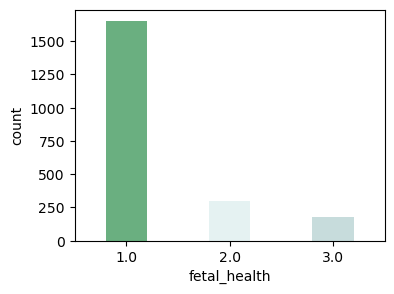

In [84]:
plt.figure(figsize=(4, 3))
sns.countplot(df,  
              x="fetal_health", 
              palette=np.array(['#5EBB7C', '#E3F4F4', '#C4DFDF']), 
              width=.4,
              orient="v",
             )
plt.show()

From the count plot we can see that there's misbalance of data, which can mislead our metrics when we use the classification accuracy metric. The performance measure that will provide better insights are:

1. `Confusion Matrix`
2. `Precision`
3. `Recall`
4. `F1 Score`

Let us evaluate the correlation matrix.

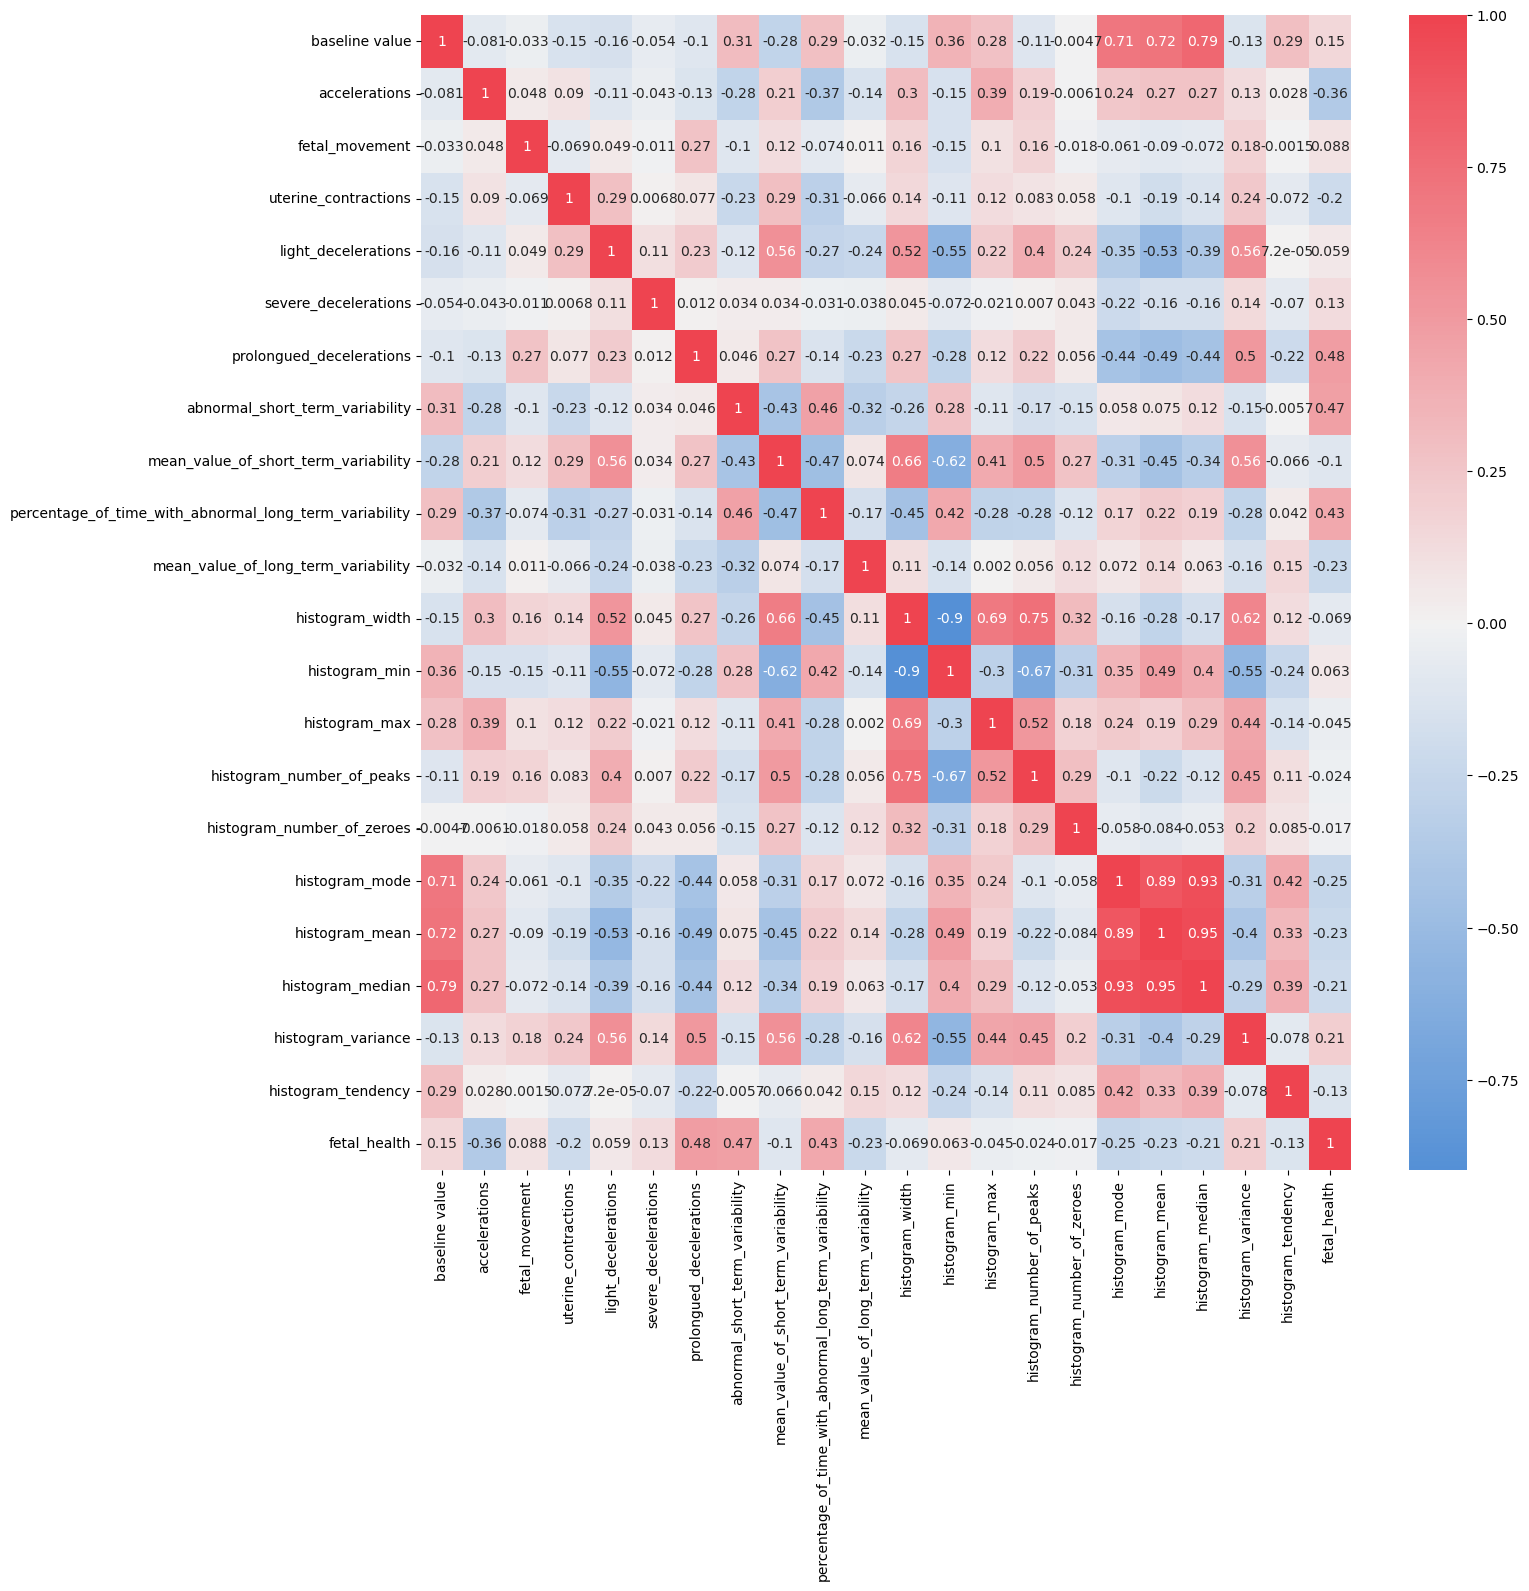

In [85]:
corrmat= df.corr()
plt.figure(figsize=(15,15))  

cmap = sns.diverging_palette(250, 10, s=80, l=55, n=9, as_cmap=True)

sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)
plt.show()

Based on the correlation matix, it is clear that `"accelerations"`,`"prolongued_decelerations"`, `"abnormal_short_term_variability"`, `"percentage_of_time_with_abnormal_long_term_variability"` and `"mean_value_of_long_term_variability"` are the features with higher correlation with fetal_health. Let's have a closer look at these with fetal_movement on y axis. This will provide a clearer picture of trends that indicate fetus health.


### Accelerations Vs Fetal Movement by Fetal Health

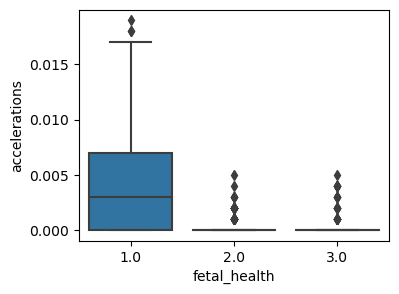

In [86]:
plt.figure(figsize=(4, 3))
sns.boxplot(df, y="accelerations",x="fetal_health")
plt.show()

### Abnormal Short Term Variability Vs Fetal Movement by Fetal Health

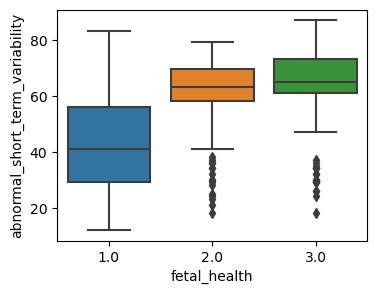

In [87]:
plt.figure(figsize=(4, 3))
sns.boxplot(df, y="abnormal_short_term_variability",x="fetal_health")
plt.show()

### Model Selection and Building

Unlike from the previous notebook, in this notebook we are going to use deep learning techniques and try to build a model that will do basic classification among the `3` fetal health categories we have. We are going to:

1. `Extract features and labels`
2. `Spliting the sets (train, validation and test)`
3. `Scales the features`
4. `Model Creation`

### Extract features and labels

In the following code cell we are going to extract all the features and labels from our giant dataframe.

In [88]:
X = df.drop(["fetal_health"],axis=1).values
y = df["fetal_health"].values

### FHCDataset

Now that we have our features and labels, we can go ahead and create a `FHCDataset` class. This class in the constructor will take in `features`, `labels`.

In [89]:
class FHCDataset(data.Dataset):
    def __init__(self, features, labels):
        super(FHCDataset, self).__init__()
        self.labels = labels
        self.features = features

    def __getitem__(self, index):
        return self.labels[index], self.features[index]

    def __len__(self):
        return len(self.labels)

### collate_fn
Our `collate_fn` is a function that will preprocess our features and labels in a `batch`. Our features need to be scaled for that we are going to use the `StandardScaler` and our labels also need to be `encoded` and for that we are going to use the `LabelEncoder` from `sklearn` the reason being our label's start at `1` and ends at `3` and we want them to start at `0` and end at `2`. Let's first define our encoder and scaler.

In [90]:
scaler = StandardScaler()
scaler.fit(X)

StandardScaler()

In [91]:
encoder = LabelEncoder()
encoder.fit(y)

LabelEncoder()

Checking the classes in the label encoder.

In [92]:
classes = encoder.classes_
classes

array([1., 2., 3.])

Now that we have our encoder and scaler we can now create a `collate_fn` that will do the preprocessing of features and labels within a batch. The collate function will do the following:

1. scale fatures in a batch.
2. encode labels in a batch.
3. convert features and labels to torch tensors.



In [93]:
def collate_fn(batch):
    labels_list, features_list = list(), list()
    for label, feature in batch:
        labels_list.append(label)
        features_list.append(feature)
    labels = encoder.transform(labels_list)
    features = scaler.transform(features_list)
    return torch.from_numpy(labels), torch.from_numpy(features)

### Spliting the sets (train, validation and test)
Then we are going to split our features and labels into train and tests sets.

In [94]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,test_size=0.2,random_state=SEED
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_val,y_train_val,test_size = 0.1,random_state=SEED
)

### Counting Example

Next we are going to count how many example do we have in each set.

In [95]:
title = "DATASETS EXAMPLES"
columns = "SET", "TOTAL"
data_rows = [("training", len(X_train)), 
             ("testing", len(X_test)),
             ('validation', len(X_valid)),
             ("total", f"{ len(X_train) + len(X_test) + len(X_valid):,}")
        ]

print(title)
tables.tabulate_data(columns, data_rows, title)

DATASETS EXAMPLES
+--------------------+
| DATASETS EXAMPLES  |
+------------+-------+
| SET        | TOTAL |
+------------+-------+
| training   |  1530 |
| testing    |   426 |
| validation |   170 |
| total      | 2,126 |
+------------+-------+


### Dataset

Let's create our datasets now using the `FHCDataset` for all the `3` sets.

In [96]:
train_dataset = FHCDataset(X_train, y_train)
test_dataset = FHCDataset(X_test, y_test)
val_dataset = FHCDataset(X_valid, y_valid)

### Iterators

In the following code cell we are going to create loaders using the `DataLoader` class from `torch.utils.data` for our `3` sets. We are going to use the `batch_size` of `8` and our `collate_function` is `collate_fn`.

In [97]:
BATCH_SIZE = 8
train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
val_loader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

### Checking Example 

Let's check a single example in our train loader.

In [98]:
lbl, feature = next(iter(train_loader))
print(lbl)

tensor([0, 0, 1, 0, 0, 0, 0, 0])


In [99]:
feature

tensor([[-1.0473e+00, -8.2239e-01, -2.0321e-01, -1.4825e+00, -6.3844e-01,
         -5.7476e-02, -2.6875e-01, -8.7209e-01, -2.6362e-01, -5.3536e-01,
          1.5483e+00,  1.4261e-01, -9.3321e-01, -1.2277e+00, -3.6226e-01,
         -4.5844e-01, -7.6032e-01, -6.1646e-01, -9.0508e-01, -5.1114e-01,
          1.1130e+00],
        [-1.9621e+00, -8.2239e-01, -2.0321e-01,  1.2337e+00, -6.3844e-01,
         -5.7476e-02, -2.6875e-01,  1.0478e+00, -9.4310e-01, -5.3536e-01,
          6.0644e-01, -1.2182e+00,  2.8493e-01, -2.1753e+00, -1.0405e+00,
         -4.5844e-01, -1.3709e+00, -1.2579e+00, -1.5273e+00, -6.4921e-01,
         -5.2453e-01],
        [ 1.7987e+00, -8.2239e-01, -2.0321e-01,  5.5463e-01,  1.3889e+00,
         -5.7476e-02, -2.6875e-01,  3.4964e-01,  1.7748e+00, -3.7225e-01,
          2.3481e+00,  2.0170e+00, -1.4408e+00,  2.0053e+00,  2.3508e+00,
          9.4581e+00,  1.1325e+00,  7.9471e-01,  1.1692e+00,  1.9396e+00,
          1.1130e+00],
        [-3.0884e-02,  1.7651e+00, -2.0321e

### Model Creation

Now that we have our loaders for each set we can go ahead and create a model that called `FHCModel`.

In [100]:
class FHCModel(nn.Module):
    def __init__(self, input_size, output_size, dropout=.5):
        super(FHCModel, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32,64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, output_size)
        )
        
    def forward(self,x):
        out = self.classifier(x)
        return out

### Model Instance

Next we are going to create a model instance. First we need to define the hyper parameters of our model.

In [101]:
input_size = feature.shape[1]
output_size = len(classes)

fhc_model = FHCModel(input_size, output_size).to(device)
fhc_model

FHCModel(
  (classifier): Sequential(
    (0): Linear(in_features=21, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=32, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=64, out_features=3, bias=True)
  )
)

### Counting model parameters

Next we are going to count how many parameters our model has.

In [102]:
models.model_params(fhc_model)

TOTAL MODEL PARAMETERS: 	3,011
TOTAL TRAINABLE PARAMETERS: 	3,011


Our model has only `3, 011` trainable and non-trainable parameters.


### Model Training

First we need to create the `optimizer` and `criterion` for our model. We are going to use the `Adam` optimizer and for the loss function we will be using `CrossEntropyLoss` since this is a multi-class classification.

In [103]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(fhc_model.parameters())

### Categorical Accuracy 

In the following code cell we are going to create a categorical accuracy function that will calculate the categorical accuracy between the predicted labels and true labels.


In [104]:
def categorical_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    return correct.float()/y.shape[0]

### train and evaluation functions

In the next code cell we are going to create our `train` and evaluation fuctions.

In [105]:
def train(model, iterator, optimizer, criterion, device):
    epoch_loss, epoch_acc = 0, 0
    model.train()
    for y, x in iterator:
        # features and labels to the device
        x = x.type(torch.float32).to(device)
        #  labels must be long tensors
        y = y.type(torch.long).to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        y_pred = y_pred.squeeze()
        loss = criterion(y_pred, y)
        acc = categorical_accuracy(y_pred, y)
        # Backward propagate
        loss.backward()
        # Update the weights
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc/len(iterator)
  

def evaluate(model, iterator, criterion, device):
    epoch_loss, epoch_acc = 0, 0
    model.eval()
    with torch.no_grad():
        for y, x in iterator:
            x = x.type(torch.float32).to(device)
            y = y.type(torch.long).to(device)
            y_pred = model(x)
            y_pred = y_pred.squeeze()
            
            loss = criterion(y_pred, y)
            acc = categorical_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        return  epoch_loss / len(iterator), epoch_acc/len(iterator)

### Training loop
We are then going to run our training loop as save the model when the previous validation loss is less that the current validation loss. We are only going to train the model for `30` epochs.

In [106]:
class History:
    def __init__(self):
        self.train_losses = list()
        self.train_acc = list()
        self.epoch_train_time = list()
        self.val_losses = list()
        self.val_acc = list()
        
    def add(self, train_loss:float, train_acc:float, val_loss:float, val_acc:float, elt:float):
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.train_acc.append(train_acc)
        self.val_acc.append(val_acc)
        self.epoch_train_time.append(elt)

In [107]:
EPOCHS = 30
best_valid_loss = float('inf')
MODEL_NAME = "fhc_model.pt"
column_names = ["Set", "Loss", "Accuracy", "ETA (time)"]
last_saved_epoch = 1

history = History()

training_start = time.time()
for epoch in range(EPOCHS):
    start = time.time()

    train_loss, train_acc = train(fhc_model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(fhc_model, val_loader, criterion, device)

    save_status = "(not saving)"
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        save_status = "(saving)"
        last_saved_epoch = epoch + 1
        torch.save(fhc_model.state_dict(), MODEL_NAME)
    end = time.time()
    history.add(train_loss, train_acc, valid_loss, valid_acc, end-start)
    data_rows = [
          ["Train", f'{train_loss:.3f}', f'{train_acc * 100:.2f}%', hms_string(end-start)],
          ["Validation", f'{valid_loss:.3f}', f'{valid_acc * 100:.2f}%', ""]
      ]
    title = f"EPOCH {epoch+1:02}/{EPOCHS}: {save_status}"
    print(title)
    tables.tabulate_data(column_names, data_rows, title)
    
training_end = time.time()

EPOCH 01/30: (saving)
+--------------------------------------------+
|           EPOCH 01/30: (saving)            |
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.709 |   75.78% | 0:00:00.22 |
| Validation | 0.448 |   79.55% |            |
+------------+-------+----------+------------+
EPOCH 02/30: (saving)
+--------------------------------------------+
|           EPOCH 02/30: (saving)            |
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.453 |   80.73% | 0:00:00.22 |
| Validation | 0.309 |   88.07% |            |
+------------+-------+----------+------------+
EPOCH 03/30: (saving)
+--------------------------------------------+
|           EPOCH 03/30: (saving)            |
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (ti

### Visualizing the training History
In this section of the notebook we are going to visualize the training history of the model over `N` epochs.

In [108]:
print("----- TOTAL TRAINING TIME ")
rows = [
      ["TOTAL EPOCHS", f'{EPOCHS}'],
      ["LAST SAVED EPOCH", f'{last_saved_epoch}'],
      ["TOTAL TRAINING TIME", f'{hms_string(training_end-training_start)}']
]
tables.tabulate_data(['', 'value'], rows, "TOTAL TRAINING TIME")

----- TOTAL TRAINING TIME 
+----------------------------------+
|       TOTAL TRAINING TIME        |
+---------------------+------------+
|                     |      value |
+---------------------+------------+
| TOTAL EPOCHS        |         30 |
| LAST SAVED EPOCH    |         27 |
| TOTAL TRAINING TIME | 0:00:06.64 |
+---------------------+------------+


Let's plot how long the model took to train each epoch from our `history` object.

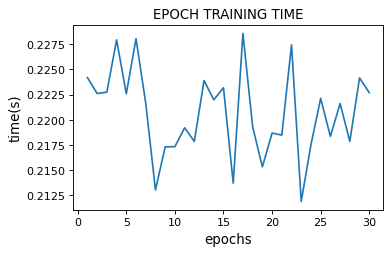

In [109]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.epoch_train_time)
plt.title("EPOCH TRAINING TIME", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("time(s)", fontsize=12)
plt.show()


Let's plot the model's training `history` in terms of `acuracy` and `losses` over `N` epochs in our train and valid sets.

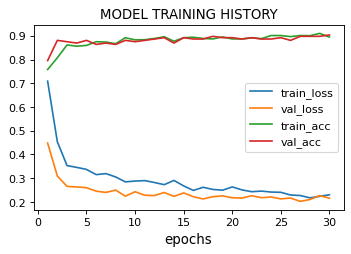

In [110]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.train_losses, label="train_loss")
plt.plot(epochs, history.val_losses, label="val_loss")
plt.plot(epochs, history.train_acc, label="train_acc")
plt.plot(epochs, history.val_acc, label="val_acc")
plt.title("MODEL TRAINING HISTORY", color="k", fontsize=12)
plt.legend()
plt.xlabel("epochs", fontsize=12)
plt.show()

Next we are going to evaluate the best model and check for the model `loss` and `accuracy` based on the unseen dataset which is the test.

In [111]:
fhc_model.load_state_dict(torch.load(MODEL_NAME))

test_loss, test_acc = evaluate(fhc_model, test_loader, criterion, device)
title = "Model Evaluation Summary"
data_rows = [["Test", f'{test_loss:.3f}', f'{test_acc * 100:.2f}%', ""]]

tables.tabulate_data(column_names, data_rows, title)

+--------------------------------------+
|       Model Evaluation Summary       |
+------+-------+----------+------------+
| Set  |  Loss | Accuracy | ETA (time) |
+------+-------+----------+------------+
| Test | 0.219 |   89.81% |            |
+------+-------+----------+------------+


### Classifier Performance

In this section we are going to have a look on how well our classifier model will be performing interms of the following metrics.

1. `Confusion Matrix`
2. `Precision`
3. `Recall`
4. `F1 Score`


### F1 Score



First let's make predictions for all our three sets, `train`, `test` and `validation`

In [112]:
X_train, X_test, X_valid = list(), list(), list()
y_train, y_test, y_valid = list(), list(), list()

for l, x in train_loader:
    X_train.extend(list(x.numpy()))
    y_train.extend(list(l))
    
for l, x in test_loader:
    X_test.extend(list(x.numpy()))
    y_test.extend(list(l))
    
for l, x in val_loader:
    X_valid.extend(list(x.numpy()))
    y_valid.extend(list(l))

In [113]:
train_preds = torch.argmax(fhc_model(torch.tensor(X_train, dtype=torch.float32)), dim=1).numpy()
test_preds = torch.argmax(fhc_model(torch.tensor(X_test, dtype=torch.float32).to(device)), dim=1).numpy()
valid_preds = torch.argmax(fhc_model(torch.tensor(X_valid, dtype=torch.float32).to(device)), dim=1).numpy()

### F1 Score on the `train` set.

In [114]:
score = f1_score(y_train, train_preds, labels=np.array([0, 1, 2], dtype=np.float32), average=None)
score

array([0.96693177, 0.77419355, 0.87763713])

This shows us that the model is able to predict the labels with the following accuracy

* `1` - `~96%`
* `2` - `~77%`
* `3` - `~88%`

In the `train` data

### F1 Score on the `validation` set.

In [115]:
score = f1_score(y_valid, valid_preds, labels=np.array([0, 1, 2], dtype=np.float32), average=None)
score

array([0.9509434 , 0.68085106, 0.92857143])

This shows us that the model is able to predict the labels with the following accuracy

* `1` - `~95%`
* `2` - `~68%`
* `3` - `~93%`

In the `validation` data


### F1 Score on the `test` set.

In [116]:
score = f1_score(y_test, test_preds, labels=np.array([0, 1, 2], dtype=np.float32), average=None)
score

array([0.94940476, 0.67213115, 0.75862069])

This shows us that the model is able to predict the labels with the following accuracy

* `1` - `~95%`
* `2` - `~67%`
* `3` - `~76%`

In the `test` data


We can safely conclude that our model is performing well in predicting `normal` fetal health more than `suspect` and `pathological` as the `F1 Score` is better on the label `1` as compared to others in all sets.


### Confusion Matrix

Next we are going to plot the confusion matrix and visually see how well our model is performing in predicting these labels and how confused it is between classes.


### train

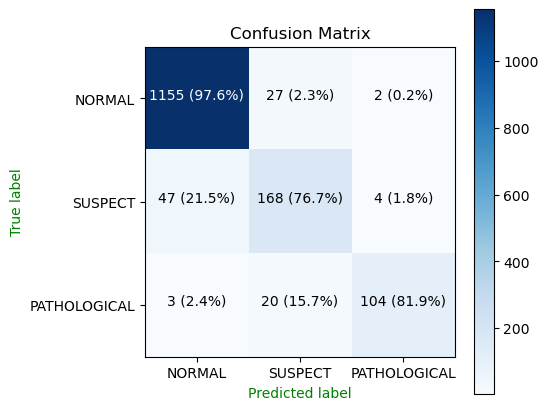

In [117]:
visualization.plot_complicated_confusion_matrix(
    y_train, train_preds, ['NORMAL', 'SUSPECT', 'PATHOLOGICAL'], 
    fontsize=10, figsize=(5, 5), 
)

### validation

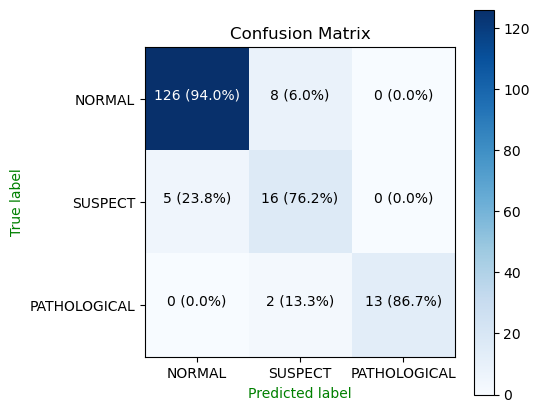

In [118]:
visualization.plot_complicated_confusion_matrix(
    y_valid, valid_preds, ['NORMAL', 'SUSPECT', 'PATHOLOGICAL'], 
    fontsize=10, figsize=(5, 5), 
)

### test

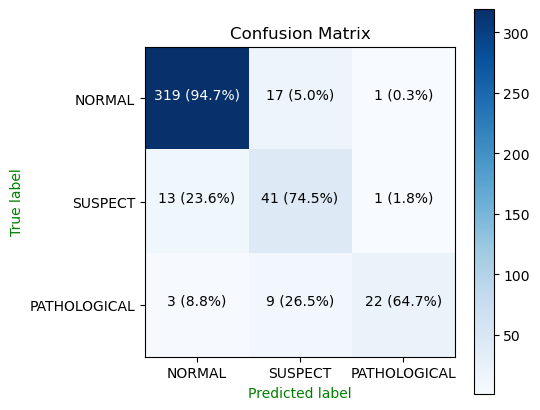

In [119]:
visualization.plot_complicated_confusion_matrix(
    y_test, test_preds, ['NORMAL', 'SUSPECT', 'PATHOLOGICAL'], 
    fontsize=10, figsize=(5, 5), 
)

### Precision Score



### train

In [120]:
precision = precision_score(y_train, train_preds, labels=np.array([0, 1, 2], dtype=np.float32), average=None)
precision

array([0.95850622, 0.78139535, 0.94545455])

This shows us that the classifier has the following positive predicted value on each class.

* `1` - `~96%`
* `2` - `~78%`
* `3` - `~9%6`

In the `train` data

### validation

In [121]:
precision = precision_score(y_valid, valid_preds, labels=np.array([0, 1, 2], dtype=np.float32), average=None)
precision

array([0.96183206, 0.61538462, 1.        ])

This shows us that the classifier has the following positive predicted value on each class.

* `1` - `~96%`
* `2` - `~61%`
* `3` - `~100%`

In the `validation` data
### test

In [122]:
precision = precision_score(y_test, test_preds, labels=np.array([0, 1, 2], dtype=np.float32), average=None)
precision

array([0.95223881, 0.6119403 , 0.91666667])

This shows us that the classifier has the following positive predicted value on each class.

* `1` - `~95%`
* `2` - `~61%`
* `3` - `~92%`

In the `test` data

### Accuracy Score

Though this is not a good measure of how our model is performing due to unbalanced examples for each label, the accuracy score can be caluculated as follows:


### train

In [123]:
train_accuracy = accuracy_score(y_train, train_preds)
valid_accuracy = accuracy_score(y_valid, valid_preds)
test_accuracy = accuracy_score(y_test, test_preds)

columns = ['SET', 'ACCURACY']
rows = [
    ['train', f'{train_accuracy * 100:.2f}%'],
    ['validation', f'{valid_accuracy * 100:.2f}%'],
    ['test', f'{test_accuracy * 100:.2f}%'],
]

tables.tabulate_data(columns, rows, 'ACCURACY SCORE')

+-----------------------+
|     ACCURACY SCORE    |
+------------+----------+
| SET        | ACCURACY |
+------------+----------+
| train      |   93.27% |
| validation |   91.18% |
| test       |   89.67% |
+------------+----------+


### Classification Report.

Let's display the classification report for each set.


### train

In [124]:
cr = classification_report(y_train, train_preds, output_dict=False)
print(cr)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1184
           1       0.78      0.77      0.77       219
           2       0.95      0.82      0.88       127

    accuracy                           0.93      1530
   macro avg       0.90      0.85      0.87      1530
weighted avg       0.93      0.93      0.93      1530



### test

In [125]:
cr = classification_report(y_test, test_preds, output_dict=False)
print(cr)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       337
           1       0.61      0.75      0.67        55
           2       0.92      0.65      0.76        34

    accuracy                           0.90       426
   macro avg       0.83      0.78      0.79       426
weighted avg       0.91      0.90      0.90       426



### validation

In [126]:
cr = classification_report(y_valid, valid_preds, output_dict=False)
print(cr)

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       134
           1       0.62      0.76      0.68        21
           2       1.00      0.87      0.93        15

    accuracy                           0.91       170
   macro avg       0.86      0.86      0.85       170
weighted avg       0.92      0.91      0.92       170



### Classifier inference

Next let's make some predictions using our classifier and see if we will accurately predict the labels:

1. `'NORMAL'`, 
2. `'SUSPECT'`, 
3. `'PATHOLOGICAL'`

In [127]:
classes = ['NORMAL', 'SUSPECT', 'PATHOLOGICAL']

Let's check the first `10` rows in our dataset.

In [128]:
df.head(12)

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.000,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.000,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.000,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.000,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.000,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0
5,134.0,0.001,0.0,0.010,0.009,0.0,0.002,26.0,5.9,0.0,...,50.0,200.0,5.0,3.0,76.0,107.0,107.0,170.0,0.0,3.0
6,134.0,0.001,0.0,0.013,0.008,0.0,0.003,29.0,6.3,0.0,...,50.0,200.0,6.0,3.0,71.0,107.0,106.0,215.0,0.0,3.0
7,122.0,0.000,0.0,0.000,0.000,0.0,0.000,83.0,0.5,6.0,...,62.0,130.0,0.0,0.0,122.0,122.0,123.0,3.0,1.0,3.0
8,122.0,0.000,0.0,0.002,0.000,0.0,0.000,84.0,0.5,5.0,...,62.0,130.0,0.0,0.0,122.0,122.0,123.0,3.0,1.0,3.0
9,122.0,0.000,0.0,0.003,0.000,0.0,0.000,86.0,0.3,6.0,...,62.0,130.0,1.0,0.0,122.0,122.0,123.0,1.0,1.0,3.0


Let's get the features for each label that we will use to test the inference of the classifier.

In [129]:
# take the features with no labels
label_2 = df.iloc[11].values[:-1] # SUSPECT
label_1 = df.iloc[1].values[:-1] # NORMAL
label_3 = df.iloc[9].values[:-1] # PATHOLOGICAL

Let's define a function called `classify_fetal` that takes in the features and make presictions of the `fetal` health.

In [130]:
class FetalPrediction:
    def __init__(self, label: int, class_:str, confidence: float) -> None:
        self.label = label
        self.class_ = class_
        self.confidence = confidence
        
    def __str__(self):
        return f"FetalPrediction: [{self.class_}]"
    
    def __repr__(self):
        return f"FetalPrediction: [{self.class_}]"
    
    def json(self):
        return {
            'class': self.class_,
            'label': self.label, 
            'confidence': self.confidence
        }
        
def classify_fetal(features, model, device):
    x = scaler.transform(np.expand_dims(features, 0))
    x = torch.from_numpy(x).type(torch.float32).to(device)
    model.eval()
    with torch.no_grad():
        preds = model(x)
        preds = F.softmax(preds, dim=1).detach().cpu().numpy().squeeze()
        index = np.argmax(preds)
        confidence = float(preds[index])
        class_ = classes[index]
        return FetalPrediction(index, class_, confidence).json()

### SUSPECT

In [131]:
classify_fetal(label_2, fhc_model, device)

{'class': 'NORMAL', 'label': 0, 'confidence': 0.5157265067100525}

### NORMAL

In [132]:
classify_fetal(label_1, fhc_model, device)

{'class': 'NORMAL', 'label': 0, 'confidence': 1.0}

### PATHOLOGICAL

In [133]:
classify_fetal(label_3, fhc_model, device)

{'class': 'PATHOLOGICAL', 'label': 2, 'confidence': 0.6422785520553589}